# Import Libraries
This cell imports all the necessary libraries for data handling, model building, training, and visualization.

- `os`: For interacting with the operating system to read file paths.
- `cv2`: OpenCV library for image processing.
- `numpy`: For numerical operations.
- `xml.etree.ElementTree`: For parsing XML files (used for annotations).
- `sklearn.model_selection`: For splitting the dataset into training and testing sets.
- `sklearn.metrics`: For evaluating the model's performance.
- `torch`: PyTorch library for building and training neural networks.
- `torch.utils.data`: For creating data loaders.
- `torch.nn`: For building neural network layers.
- `torch.optim`: For optimization algorithms.
- `matplotlib.pyplot`: For plotting graphs.
- `seaborn`: For creating visually appealing plots.


In [1]:
import os
import cv2
import random
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns


# Check for CUDA
This cell checks if CUDA is available for GPU acceleration. If not, it falls back to using the CPU.
- `torch.device`: PyTorch function to set the device for tensor operations.
- `torch.cuda.is_available()`: Checks if CUDA is available.


In [2]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load Images and Labels
This function loads images and corresponding labels from the specified folders, converts images to grayscale, resizes them, and flattens them into 1D arrays.

- `image_folder`: Path to the folder containing images.
- `annotation_folder`: Path to the folder containing XML annotation files.
- `img_size`: Target size to resize images.
- `os.listdir()`: Lists all files in the specified directory.
- `cv2.imread()`: Reads an image from a file.
- `cv2.cvtColor()`: Converts an image from one color space to another.
- `cv2.resize()`: Resizes an image.
- `ET.parse()`: Parses an XML file.
- `root.findall()`: Finds all matching elements in the XML tree.


In [3]:
# Folder paths
image_folder = 'dataset/images'
annotation_folder = 'dataset/annotations'
img_size = (64, 64)  # Resize images to 64x64

def load_images_and_labels(image_folder, annotation_folder, img_size):
    images = []
    labels = []
    for img_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_file)
        xml_file = img_file.split('.')[0] + '.xml'
        xml_path = os.path.join(annotation_folder, xml_file)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, img_size)
        img = img.flatten()
        images.append(img)
        
        label = 0
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == 'with_mask':
                label = 1
                break
            elif name == 'mask_weared_incorrect':
                label = 2
                break
        labels.append(label)
        
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(image_folder, annotation_folder, img_size)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)


# Check and Balance the Dataset
This cell checks the distribution of classes in the training dataset and prints the distribution to ensure the dataset is balanced.

- `np.unique()`: Finds the unique elements of an array.
- `np.array()`: Creates an array.
- `zip()`: Aggregates elements from multiple iterables.
- `dict()`: Creates a dictionary.


In [4]:
# Check and balance the dataset
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"Training set distribution: {class_distribution}")


Training set distribution: {0: 36, 1: 448, 2: 27}


# Prepare Data Loaders
This function prepares data loaders for the training and testing datasets, which are used to feed data into the model in batches.

- `torch.Tensor()`: Creates a tensor.
- `torch.LongTensor()`: Creates a tensor of type long.
- `TensorDataset()`: Combines multiple tensors into a dataset.
- `DataLoader()`: Creates a data loader for the dataset.
- `batch_size`: Number of samples per batch.
- `shuffle`: Whether to shuffle the data at every epoch.
- `num_workers`: Number of subprocesses to use for data loading.


In [5]:
def create_data_loader(X, y, batch_size=32):
    tensor_x = torch.Tensor(X)
    tensor_y = torch.LongTensor(y)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

train_loader = create_data_loader(X_train, y_train)
test_loader = create_data_loader(X_test, y_test)


# Define Improved Neural Network Model
In this step, we define an improved neural network model called `ImprovedNN`. The neural network consists of multiple layers to enhance its ability to learn complex patterns from the input data. This model includes three fully connected (dense) layers with ReLU activation functions. 

The detailed architecture is as follows:

1. **Input Layer**:
    - Input size: 64 * 64 (4096 features), representing the flattened grayscale image.

2. **First Hidden Layer**:
    - Fully Connected Layer (Linear Layer) with 256 units.
    - Activation Function: ReLU (Rectified Linear Unit), which introduces non-linearity and helps the network learn complex patterns.

3. **Second Hidden Layer**:
    - Fully Connected Layer (Linear Layer) with 128 units.
    - Activation Function: ReLU, similar to the first hidden layer.

4. **Output Layer**:
    - Fully Connected Layer (Linear Layer) with 3 units, corresponding to the three classes: without mask, with mask, and mask worn incorrectly.
    - This layer produces the raw output scores (logits) for each class.

The `forward` method defines the forward pass through the network, which computes the output for a given input by passing it through the defined layers and activation functions sequentially.


In [6]:
class ImprovedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


# Meta-Learning Loop
In this step, we implement the Model-Agnostic Meta-Learning (MAML) training loop using the `maml_train` function. MAML is a meta-learning technique designed to train models that can quickly adapt to new tasks with a few gradient updates. The training loop involves both an inner loop (task-specific adaptation) and an outer loop (meta-optimization).

Here's a detailed breakdown of the `maml_train` function:

1. **Initialization**:
    - `train_losses`, `val_losses`, and `val_accuracies` are lists to store the training loss, validation loss, and validation accuracy at each iteration.

2. **Outer Loop (Meta-Optimization Loop)**:
    - This loop runs for a specified number of iterations (`num_iterations`). In each iteration, we perform the following steps:
    - Clear the gradients of the meta-optimizer using `meta_optimizer.zero_grad()`.

3. **Task Loop**:
    - For each task (comprising a train loader and a test loader), we:
    - Print the current iteration and task number for tracking progress.

4. **Clone Initial Weights**:
    - Clone the model's initial weights (`fast_weights`) before performing task-specific adaptation. This ensures that the model starts with the same initial weights for each task.

5. **Inner Loop (Task-Specific Adaptation)**:
    - This loop runs for a specified number of steps (`num_inner_steps`). In each step, we:
    - Iterate through the batches in the train loader.
    - Perform a forward pass to compute the predictions (`preds`).
    - Compute the task-specific loss using `nn.CrossEntropyLoss`.
    - Compute the gradients of the loss with respect to the fast weights using `torch.autograd.grad`.
    - Update the fast weights using the computed gradients and the inner loop learning rate (`inner_lr`).

6. **Compute Meta-Loss**:
    - After adapting the model to the task, iterate through the batches in the test loader.
    - Perform a forward pass to compute the predictions and compute the loss using the adapted weights.
    - Accumulate the loss across all tasks to compute the meta-loss.

7. **Meta-Optimization**:
    - Perform a backward pass to compute the gradients of the meta-loss with respect to the initial weights.
    - Update the initial weights using the meta-optimizer (`meta_optimizer.step()`).

8. **Logging and Validation**:
    - Log the training loss for the current iteration.
    - Perform validation by calling the `evaluate_model` function and log the validation loss and accuracy.

9. **Plotting**:
    - Plot the training and validation loss, and validation accuracy over the iterations using Matplotlib.

In [7]:
def maml_train(model, meta_optimizer, tasks, num_iterations=1000, num_inner_steps=5, inner_lr=0.01):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for iteration in range(num_iterations):
        meta_optimizer.zero_grad()
        
        meta_loss = 0
        for i, (train_loader, test_loader) in enumerate(tasks):
            print(f"Iteration {iteration+1}/{num_iterations}, Task {i+1}/{len(tasks)}")

            fast_weights = [w.clone() for w in model.parameters()]
            
            for step in range(num_inner_steps):
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    preds = model(x)
                    loss = nn.CrossEntropyLoss()(preds, y)
                    grads = torch.autograd.grad(loss, fast_weights, create_graph=True, allow_unused=True)
                    fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
            
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                meta_loss += loss
        
        meta_loss.backward()
        meta_optimizer.step()

        # Logging training loss
        train_losses.append(meta_loss.item())
        
        # Validation
        val_loss, val_acc = evaluate_model(model, tasks)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot([acc * 100 for acc in val_accuracies], label='Validation Accuracy (%)')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


# Evaluation Function
This function evaluates the model on the validation tasks, returning the validation loss and accuracy.

- `model.eval()`: Sets the model to evaluation mode.
- `with torch.no_grad()`: Disables gradient calculation.
- `correct += (preds.argmax(dim=1) == y).sum().item()`: Counts the number of correct predictions.
- `total += y.size(0)`: Counts the total number of predictions.
- `model.train()`: Sets the model back to training mode.


In [8]:
def evaluate_model(model, tasks):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for train_loader, test_loader in tasks:
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                val_loss += loss.item()
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)
    model.train()
    return val_loss / len(tasks), correct / total


# Create Tasks for Meta-Learning

In this step, we create tasks for the meta-learning process. A task in this context consists of a training dataset and a testing dataset. The idea is to simulate the model's learning and adaptation process on a variety of different tasks. This helps the model learn a more generalizable solution that can adapt quickly to new tasks.

The `create_tasks` function generates multiple such tasks by splitting the dataset into different train-test splits. This approach ensures that the model experiences diverse learning scenarios during meta-training.

Here’s a detailed breakdown of the `create_tasks` function:

1. **Parameters**:
    - `X`: The array of input features (images).
    - `y`: The array of labels corresponding to the input features.
    - `num_tasks`: The number of tasks to create. Each task is a unique train-test split of the dataset.
    - `task_split`: The proportion of the dataset to include in the test split for each task.

2. **Initialization**:
    - Initialize an empty list `tasks` to store the created tasks.

3. **Task Creation Loop**:
    - Loop `num_tasks` times to create the specified number of tasks.

4. **Train-Test Split**:
    - For each iteration, split the dataset `X` and `y` into training and testing sets using `train_test_split` from `sklearn.model_selection`. The `test_size` parameter is set to `task_split` to determine the proportion of the dataset used for testing in each task.

5. **Create Data Loaders**:
    - Create data loaders for the training and testing sets using the `create_data_loader` function. Data loaders are essential for efficiently feeding data into the model during training and evaluation.

6. **Store the Task**:
    - Append a tuple `(train_loader, test_loader)` to the `tasks` list. Each tuple represents a task consisting of a training data loader and a testing data loader.

7. **Return Tasks**:
    - After creating all tasks, return the `tasks` list.

The goal of creating multiple tasks is to expose the model to a variety of learning scenarios. This enhances the model's ability to generalize and adapt to new, unseen tasks during meta-training.


In [9]:
def create_tasks(X, y, num_tasks=10, task_split=0.5):
    tasks = []
    for _ in range(num_tasks):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=task_split)
        train_loader = create_data_loader(X_train, y_train)
        test_loader = create_data_loader(X_test, y_test)
        tasks.append((train_loader, test_loader))
    return tasks

tasks = create_tasks(images, labels)


# Initialize and Train Model
This cell initializes the improved neural network model and trains it using MAML on the created tasks.

- `input_size`: The size of the input features (64x64 pixels).
- `num_classes`: The number of classes (3: without mask, with mask, mask worn incorrectly).
- `ImprovedNN()`: Initializes the improved neural network model.
- `optim.Adam()`: Initializes the Adam optimizer.


Iteration 1/1000, Task 1/10
Iteration 1/1000, Task 2/10
Iteration 1/1000, Task 3/10
Iteration 1/1000, Task 4/10
Iteration 1/1000, Task 5/10
Iteration 1/1000, Task 6/10
Iteration 1/1000, Task 7/10
Iteration 1/1000, Task 8/10
Iteration 1/1000, Task 9/10
Iteration 1/1000, Task 10/10
Iteration 2/1000, Task 1/10
Iteration 2/1000, Task 2/10
Iteration 2/1000, Task 3/10
Iteration 2/1000, Task 4/10
Iteration 2/1000, Task 5/10
Iteration 2/1000, Task 6/10
Iteration 2/1000, Task 7/10
Iteration 2/1000, Task 8/10
Iteration 2/1000, Task 9/10
Iteration 2/1000, Task 10/10
Iteration 3/1000, Task 1/10
Iteration 3/1000, Task 2/10
Iteration 3/1000, Task 3/10
Iteration 3/1000, Task 4/10
Iteration 3/1000, Task 5/10
Iteration 3/1000, Task 6/10
Iteration 3/1000, Task 7/10
Iteration 3/1000, Task 8/10
Iteration 3/1000, Task 9/10
Iteration 3/1000, Task 10/10
Iteration 4/1000, Task 1/10
Iteration 4/1000, Task 2/10
Iteration 4/1000, Task 3/10
Iteration 4/1000, Task 4/10
Iteration 4/1000, Task 5/10
Iteration 4/1000,

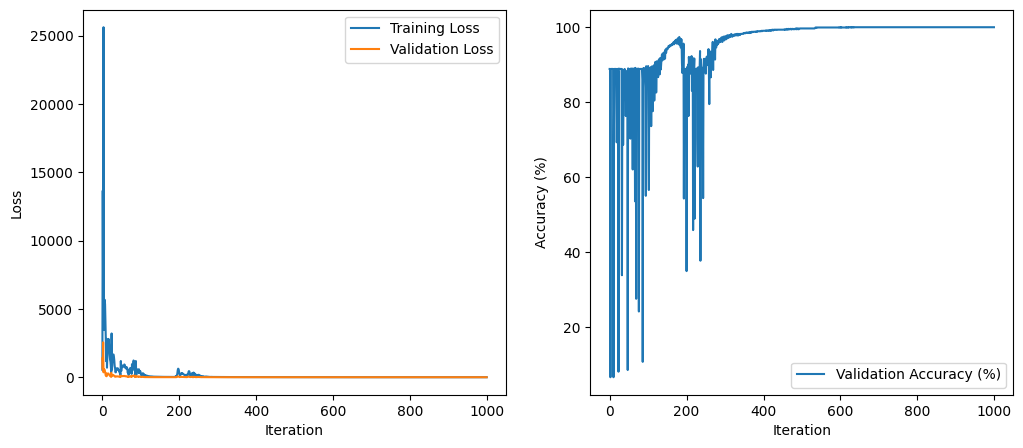

In [10]:
input_size = 64 * 64
num_classes = 3
model = ImprovedNN(input_size, num_classes).to(device)
meta_optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train using MAML
maml_train(model, meta_optimizer, tasks)


# Adapt and Evaluate Model
This function adapts the trained model to a specific task, evaluates it, and prints the classification report, confusion matrix, overall accuracy, and the total number of labels for each class.

- `classification_report()`: Generates a report showing the main classification metrics.
- `confusion_matrix()`: Computes the confusion matrix to evaluate the accuracy of a classification.
- `sns.heatmap()`: Plots the confusion matrix as a heatmap.
- `np.trace()`: Computes the sum along the diagonal of the confusion matrix (true positives).
- `np.sum()`: Computes the total sum of elements.
- `dict()`: Creates a dictionary for the total number of labels for each class.


                       precision    recall  f1-score   support

         without mask       1.00      1.00      1.00        24
            with mask       1.00      1.00      1.00       307
mask weared incorrect       1.00      1.00      1.00        11

             accuracy                           1.00       342
            macro avg       1.00      1.00      1.00       342
         weighted avg       1.00      1.00      1.00       342



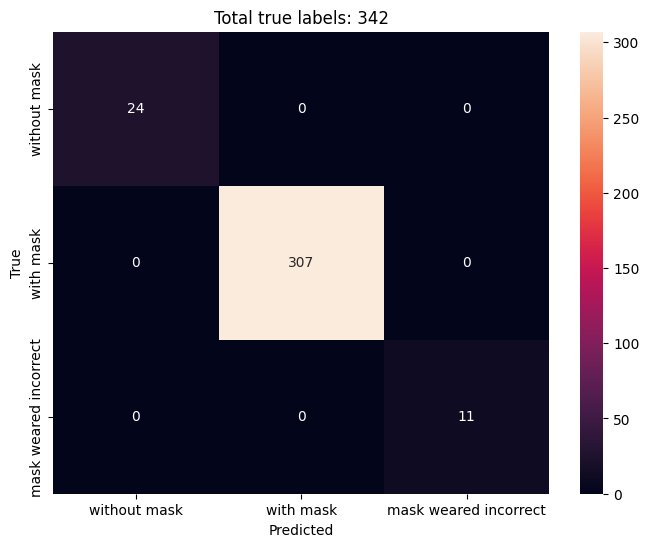

Accuracy: 100.00%
Total labels of each class: {'without mask': 24, 'with mask': 307, 'mask weared incorrect': 11}


In [11]:
def adapt_and_evaluate(model, train_loader, test_loader, num_inner_steps=5, inner_lr=0.01):
    fast_weights = [w.clone() for w in model.parameters()]
    for step in range(num_inner_steps):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = nn.CrossEntropyLoss()(preds, y)
            grads = torch.autograd.grad(loss, fast_weights, allow_unused=True)
            fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
    
    all_preds = []
    all_labels = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        all_preds.extend(preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    
    print(classification_report(all_labels, all_preds, target_names=['without mask', 'with mask', 'mask weared incorrect']))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['without mask', 'with mask', 'mask weared incorrect'], yticklabels=['without mask', 'with mask', 'mask weared incorrect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Total true labels: {sum(cm.flatten())}')
    plt.show()

    # Print accuracy
    accuracy = (np.trace(cm) / float(np.sum(cm))) * 100
    print(f'Accuracy: {accuracy:.2f}%')

    # Print total labels of each class
    total_labels = dict(zip(['without mask', 'with mask', 'mask weared incorrect'], np.sum(cm, axis=1)))
    print(f'Total labels of each class: {total_labels}')

adapt_and_evaluate(model, train_loader, test_loader)


# Display Multiple Predicted Images

This cell selects 25 random images from the test set, passes them through the trained model to get predictions, and displays the images along with the true and predicted labels.


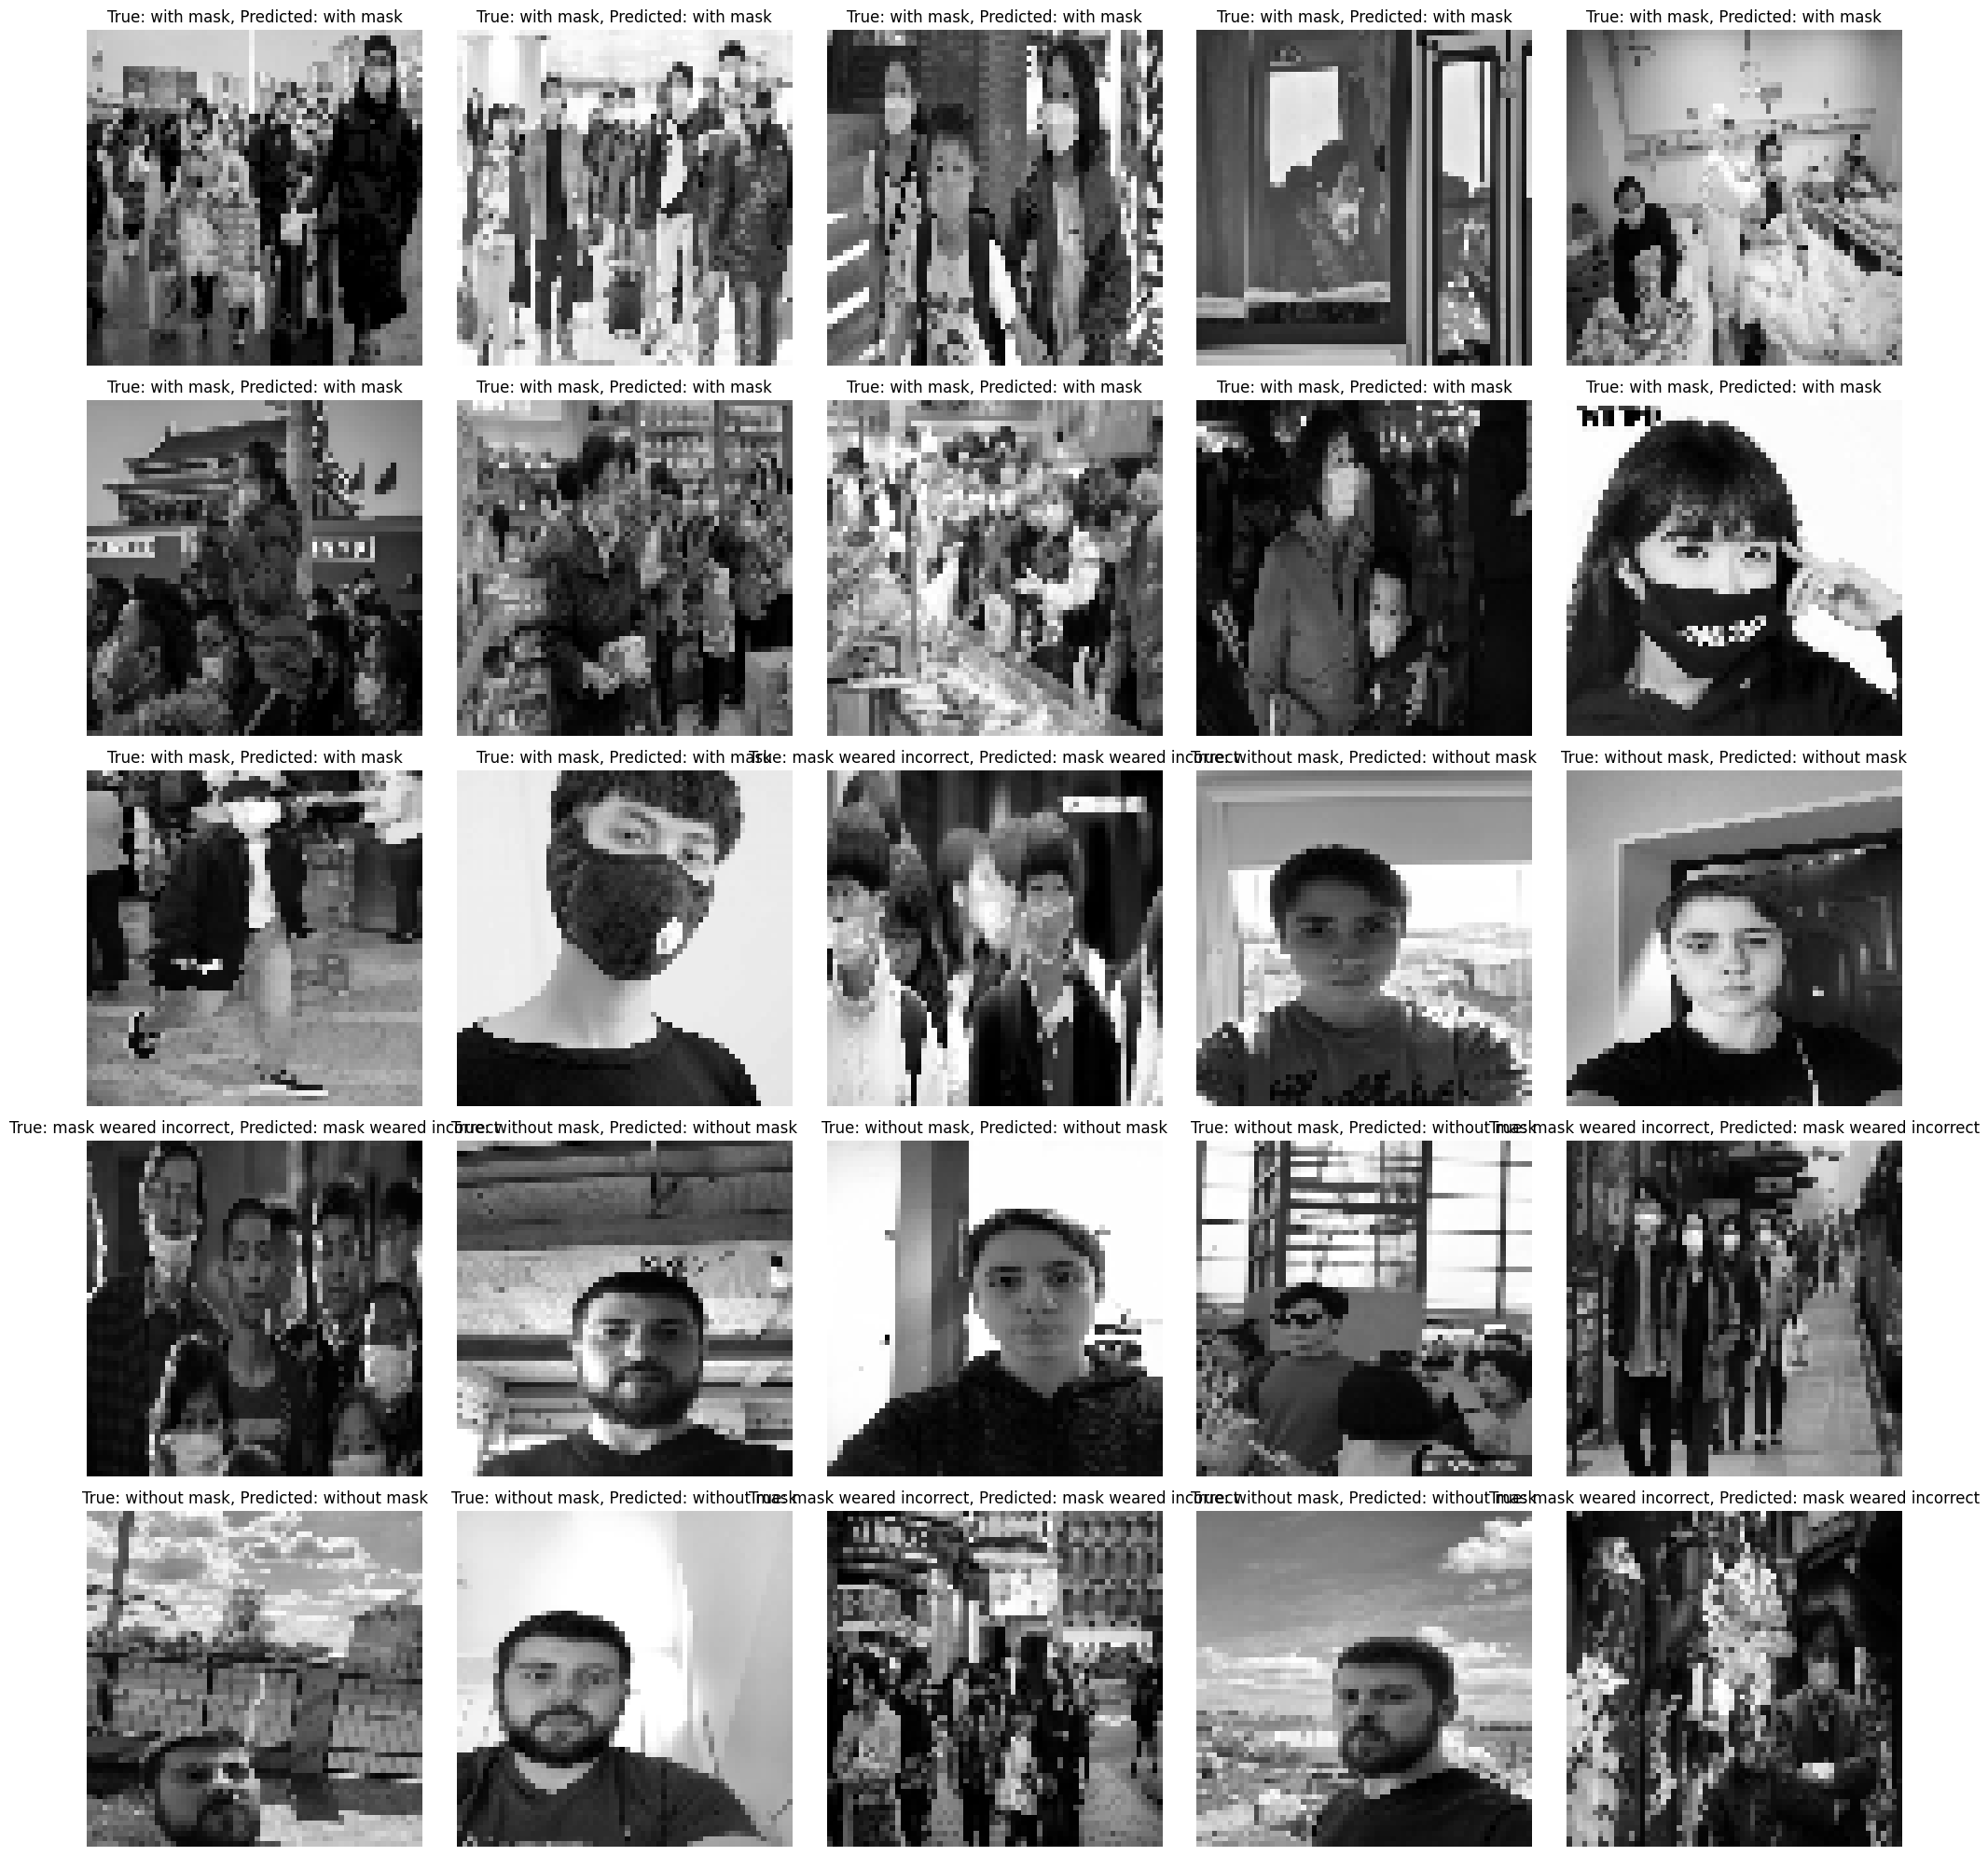

In [16]:
# Function to display specific number of predicted images per class
def show_class_specific_predictions(model, test_loader):
    model.eval()
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    axs = axs.flatten()
    
    class_names = ['without mask', 'with mask', 'mask weared incorrect']
    class_counts = {'without mask': 8, 'with mask': 12, 'mask weared incorrect': 5}
    displayed_counts = {'without mask': 0, 'with mask': 0, 'mask weared incorrect': 0}
    
    with torch.no_grad():
        for x, y in test_loader:
            for i in range(len(x)):
                img, true_label = x[i].unsqueeze(0).to(device), y[i].item()
                preds = model(img)
                predicted_label = preds.argmax(dim=1).item()
                class_name = class_names[predicted_label]
                
                if displayed_counts[class_name] < class_counts[class_name]:
                    # Convert the image to numpy array for display
                    img = img.cpu().numpy().reshape(64, 64)
                    
                    # Display the image
                    axs_idx = sum(displayed_counts.values())
                    if axs_idx >= len(axs):
                        break
                    axs[axs_idx].imshow(img, cmap='gray')
                    axs[axs_idx].set_title(f"True: {class_names[true_label]}, Predicted: {class_name}")
                    axs[axs_idx].axis('off')
                    
                    displayed_counts[class_name] += 1
                    
                    if sum(displayed_counts.values()) == 25:
                        plt.tight_layout()
                        plt.show()
                        return

# Call the function to display class-specific predictions
show_class_specific_predictions(model, test_loader)
